In [14]:
import os
from os.path import join
from time import time
from importlib import reload
import re
import numpy as np
from numpy.linalg import norm
import matplotlib.pylab as plt
import torch
import torch.optim as optim
import torch.nn.functional as F

In [57]:
import matplotlib

In [62]:
matplotlib.use("nbAgg")

In [3]:
import sys
# sys.path.append(r"D:\Github\PerceptualSimilarity")
sys.path.append(r'E:\Github_Projects\PerceptualSimilarity')
import models  # from PerceptualSimilarity folder
model_squ = models.PerceptualLoss(model='net-lin', net='squeeze', use_gpu=1, gpu_ids=[0])
model_vgg = models.PerceptualLoss(model='net-lin', net='vgg', use_gpu=1, gpu_ids=[0])
model_alex = models.PerceptualLoss(model='net-lin', net='alex', use_gpu=1, gpu_ids=[0])

Setting up Perceptual loss...


Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to C:\Users\binxu/.cache\torch\checkpoints\squeezenet1_1-f364aa15.pth
100%|█████████████████████████████████████████████████████████████████████████████| 4.74M/4.74M [00:00<00:00, 13.9MB/s]


Loading model from: E:\Github_Projects\PerceptualSimilarity\models\weights\v0.1\squeeze.pth
...[net-lin [squeeze]] initialized
...Done
Setting up Perceptual loss...
Loading model from: E:\Github_Projects\PerceptualSimilarity\models\weights\v0.1\vgg.pth
...[net-lin [vgg]] initialized
...Done
Setting up Perceptual loss...
Loading model from: E:\Github_Projects\PerceptualSimilarity\models\weights\v0.1\alex.pth
...[net-lin [alex]] initialized
...Done


In [1]:
from torch_net_utils import load_generator, load_caffenet, visualize, preprocess
net_torch = load_caffenet()
G_torch = load_generator()

create conv1                (   3 x  227 x  227) -> (  96 x   55 x   55)
create relu1                (  96 x   55 x   55) -> (  96 x   55 x   55)
create pool1                (  96 x   55 x   55) -> (  96 x   27 x   27)
create norm1                (  96 x   27 x   27) -> (  96 x   27 x   27)
create conv2                (  96 x   27 x   27) -> ( 256 x   27 x   27)
create relu2                ( 256 x   27 x   27) -> ( 256 x   27 x   27)
create pool2                ( 256 x   27 x   27) -> ( 256 x   13 x   13)
create norm2                ( 256 x   13 x   13) -> ( 256 x   13 x   13)
create conv3                ( 256 x   13 x   13) -> ( 384 x   13 x   13)
create relu3                ( 384 x   13 x   13) -> ( 384 x   13 x   13)
create conv4                ( 384 x   13 x   13) -> ( 384 x   13 x   13)
create relu4                ( 384 x   13 x   13) -> ( 384 x   13 x   13)
create conv5                ( 384 x   13 x   13) -> ( 256 x   13 x   13)
create relu5                ( 256 x   13 x   13) ->

In [9]:
G_torch.cuda()

CaffeNet(
  (defc7): Sequential(
    (0): view(nB, -1)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
  )
  (relu_defc7): LeakyReLU(negative_slope=0.3, inplace=True)
  (defc6): Sequential(
    (0): view(nB, -1)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
  )
  (relu_defc6): LeakyReLU(negative_slope=0.3, inplace=True)
  (defc5): Sequential(
    (0): view(nB, -1)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
  )
  (relu_defc5): LeakyReLU(negative_slope=0.3, inplace=True)
  (reshape): Reshape(dims=[1, 256, 4, 4])
  (deconv5): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu_deconv5): LeakyReLU(negative_slope=0.3, inplace=True)
  (conv5_1): ConvTranspose2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_conv5_1): LeakyReLU(negative_slope=0.3, inplace=True)
  (deconv4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu_deconv4): LeakyReLU(negativ

In [11]:
BGR_mean = torch.tensor([104.0, 117.0, 123.0])
BGR_mean = torch.reshape(BGR_mean, (1, 3, 1, 1))
def torch_visualize(G, code, mode="cuda"):
    """Do the De-caffe transform (Validated)
    works for a single code """
    code = code.reshape(-1, 4096).astype(np.float32)
    blobs = G(torch.from_numpy(code).cuda())
    out_img = blobs['deconv0']  # get raw output image from GAN
    clamp_out_img = torch.clamp(out_img + BGR_mean.cuda(), 0, 255)
    vis_img = clamp_out_img[:, [2, 1, 0], :, :] / 255
    return vis_img

In [12]:
sigma = 3.0
codes = sigma * np.random.randn(40, 4096)
img_list = [torch_visualize(G_torch, code, "cuda") for code in codes]
dist_mat = np.zeros((len(codes), len(codes)))
for i in range(len(codes)):
    for j in range(len(codes)):
        dist = model_vgg.forward(img_list[i], img_list[j], normalize=True)
        dist_mat[i, j] = dist.squeeze().detach().cpu().numpy()
dist_mat.mean()

0.5879506269097328

## Sample Diversity and Heredity 
This part is devoted to test that using linear encoded exploration vs spherical encoded exploration, the comparison is about compare the 

* Image Distance to Basis vector
* Among offsprings 

with linear exploration vs spherical exploration, at different norms of the basis vector. 

In [34]:
print("Perceptual Similarity Based on VGG")
basis_dist_col = []
dist_mat_col = []
for i in range(5):
    basis = 0 * np.random.randn(1, 4096)
    sigma = 3.0
    codes = sigma * np.random.randn(40, 4096) + basis
    code_norm = norm(codes, axis=1)
    print("Norm of Basis %.2f "% norm(basis))
    print("Mean norm of exploration vector %.2f (%.2f, %.2f)"% (code_norm.mean(), code_norm.min(), code_norm.max()))
    img_basis = torch_visualize(G_torch, basis, "cuda")
    img_list = [torch_visualize(G_torch, code, "cuda") for code in codes]

    dist_mat = np.zeros((len(codes), len(codes)))
    dist_to_basis = np.zeros(len(codes))
    for i in range(len(codes)):
        dist = model_vgg.forward(img_list[i], img_basis, normalize=True)
        dist_to_basis[i] = dist.squeeze().detach().cpu().numpy()
        for j in range(i+1, len(codes)):
            dist = model_vgg.forward(img_list[i], img_list[j], normalize=True)
            dist_mat[i, j] = dist.squeeze().detach().cpu().numpy()
    print("Mean distance to basis image %.2f (%.2f, %.2f)"%(dist_to_basis.mean(), dist_to_basis.min(), dist_to_basis.max()))
    dist_mat_vect = dist_mat[dist_mat.nonzero()]
    print("Mean distance among samples %.2f (%.2f, %.2f)"%(dist_mat_vect.mean(), dist_mat_vect.min(), dist_mat_vect.max()))
    basis_dist_col.append(dist_to_basis)
    dist_mat_col.append(dist_mat_vect)

Perceptual Similarity Based on VGG
Norm of Basis 0.00 
Mean norm of exploration vector 192.28 (188.93, 197.91)
Mean distance to basis image 0.60 (0.52, 0.69)
Mean distance among samples 0.59 (0.52, 0.68)
Norm of Basis 0.00 
Mean norm of exploration vector 191.95 (187.05, 196.33)
Mean distance to basis image 0.61 (0.56, 0.70)
Mean distance among samples 0.60 (0.50, 0.72)
Norm of Basis 0.00 
Mean norm of exploration vector 191.41 (187.82, 195.00)
Mean distance to basis image 0.60 (0.54, 0.66)
Mean distance among samples 0.59 (0.52, 0.69)
Norm of Basis 0.00 
Mean norm of exploration vector 192.25 (187.53, 194.52)
Mean distance to basis image 0.60 (0.54, 0.72)
Mean distance among samples 0.60 (0.51, 0.72)
Norm of Basis 0.00 
Mean norm of exploration vector 192.02 (186.86, 196.58)
Mean distance to basis image 0.60 (0.53, 0.67)
Mean distance among samples 0.59 (0.51, 0.68)


In [35]:
print("Perceptual Similarity Based on VGG")
basis_dist_col = []
dist_mat_col = []
for ampl in [0, 2, 5, 8, 10]:
    basis = ampl * np.random.randn(1, 4096)
    sigma = 3.0
    codes = sigma * np.random.randn(40, 4096) + basis
    code_norm = norm(codes, axis=1)
    print("\nNorm of Basis %.2f "% norm(basis))
    print("Mean norm of exploration vector %.2f (%.2f, %.2f)"% (code_norm.mean(), code_norm.min(), code_norm.max()))
    img_basis = torch_visualize(G_torch, basis, "cuda")
    img_list = [torch_visualize(G_torch, code, "cuda") for code in codes]

    dist_mat = np.zeros((len(codes), len(codes)))
    dist_to_basis = np.zeros(len(codes))
    for i in range(len(codes)):
        dist = model_vgg.forward(img_list[i], img_basis, normalize=True)
        dist_to_basis[i] = dist.squeeze().detach().cpu().numpy()
        for j in range(i+1, len(codes)):
            dist = model_vgg.forward(img_list[i], img_list[j], normalize=True)
            dist_mat[i, j] = dist.squeeze().detach().cpu().numpy()
    print("Mean distance to basis image %.2f (%.2f, %.2f)"%(dist_to_basis.mean(), dist_to_basis.min(), dist_to_basis.max()))
    dist_mat_vect = dist_mat[dist_mat.nonzero()]
    print("Mean distance among samples %.2f (%.2f, %.2f)"%(dist_mat_vect.mean(), dist_mat_vect.min(), dist_mat_vect.max()))
    basis_dist_col.append(dist_to_basis)
    dist_mat_col.append(dist_mat_vect)

Perceptual Similarity Based on VGG

Norm of Basis 0.00 
Mean norm of exploration vector 192.14 (186.37, 195.26)
Mean distance to basis image 0.59 (0.54, 0.69)
Mean distance among samples 0.59 (0.51, 0.71)

Norm of Basis 129.16 
Mean norm of exploration vector 231.62 (226.52, 236.61)
Mean distance to basis image 0.51 (0.45, 0.59)
Mean distance among samples 0.58 (0.50, 0.68)

Norm of Basis 321.75 
Mean norm of exploration vector 374.29 (368.65, 379.76)
Mean distance to basis image 0.37 (0.33, 0.43)
Mean distance among samples 0.45 (0.38, 0.52)

Norm of Basis 504.64 
Mean norm of exploration vector 539.62 (534.60, 546.80)
Mean distance to basis image 0.33 (0.29, 0.38)
Mean distance among samples 0.43 (0.35, 0.52)

Norm of Basis 633.13 
Mean norm of exploration vector 661.98 (655.43, 668.97)
Mean distance to basis image 0.23 (0.20, 0.30)
Mean distance among samples 0.31 (0.23, 0.40)


In [43]:
from os.path import join
result_dir = r"C:\Users\ponce\OneDrive - Washington University in St. Louis\Artiphysiology\Sample_Diversity"
result_dir = r"C:\Users\binxu\OneDrive - Washington University in St. Louis\Artiphysiology\Sample_Diversity"
basis_norm = [0.0, 129.16, 321.75, 504.64, 633.13]
explor_norm = [192.14, 231.62, 374.29, 539.62, 661.98]
np.savez(join(result_dir,"Repr_Dist.npz"), basis_dist_col=basis_dist_col, dist_mat_col=dist_mat_col, 
         basis_norm=basis_norm, explor_norm=explor_norm)

In [79]:
norm(3.0*np.random.randn(1,4096))

189.9410527614984

<IPython.core.display.Javascript object>


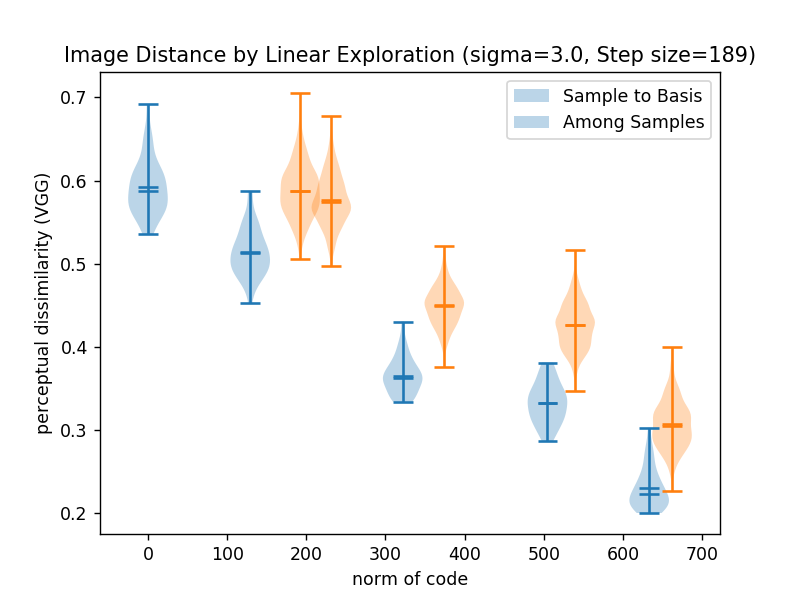

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [80]:
plt.figure()
plt.violinplot(basis_dist_col, basis_norm, points=50, widths=50,
            showmeans=True, showextrema=True, showmedians=True)
plt.violinplot(dist_mat_col, explor_norm, points=50, widths=50,
            showmeans=True, showextrema=True, showmedians=True)
plt.xlabel("norm of code")
plt.ylabel("perceptual dissimilarity (VGG)")
plt.legend(["Sample to Basis","Among Samples"])
plt.title("Image Distance by Linear Exploration (sigma=3.0, Step size=189)")
plt.savefig(join(result_dir,"SampleSimilarity_Linear.png"))
plt.savefig(join(result_dir,"SampleSimilarity_Linear.eps"), format='eps')
plt.show()

In [49]:
from ZO_HessAware_Optimizers import ExpMap
def ExpMap(x, tang_vec, EPS = 1E-4):
    angle_dist = np.sqrt((tang_vec ** 2).sum(axis=1))  # vectorized
    angle_dist = angle_dist[:, np.newaxis]
    uni_tang_vec = tang_vec / angle_dist
    # x = repmat(x, size(tang_vec, 1), 1); # vectorized
    xnorm = np.linalg.norm(x)
    assert(xnorm > EPS, "Exponential Map from a basis point at origin is degenerate, examine the code. (May caused by 0 initialization)")
    y = (np.cos(angle_dist) @ (x[:] / xnorm) + np.sin(angle_dist) * uni_tang_vec) * xnorm
    return y

<ipython-input-49-4b6bc1613863>:8: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(xnorm > EPS, "Exponential Map from a basis point at origin is degenerate, examine the code. (May caused by 0 initialization)")


In [75]:
mu = 0.005
print("Perceptual Similarity Based on VGG, Spherical Exploration")
basis_norm_col = []
basis_dist_sph_col = []
dist_mat_sph_col = []
for ampl in [2, 3, 5, 8, 10]:
    basis = ampl * np.random.randn(1, 4096)
    tang_vecs = mu * np.random.randn(40, 4096)
    codes = ExpMap(basis, tang_vecs)
    tang_code_norm = norm(tang_vecs, axis=1)
    print("\nNorm of Basis %.2f "% norm(basis))
    print("Mean norm of angular exploration vector %.2f (%.2f, %.2f)"% (tang_code_norm.mean(), tang_code_norm.min(), tang_code_norm.max()))
    basis_norm_col.append(norm(basis))
    img_basis = torch_visualize(G_torch, basis, "cuda")
    img_list = [torch_visualize(G_torch, code, "cuda") for code in codes]

    dist_mat = np.zeros((len(codes), len(codes)))
    dist_to_basis = np.zeros(len(codes))
    for i in range(len(codes)):
        dist = model_vgg.forward(img_list[i], img_basis, normalize=True)
        dist_to_basis[i] = dist.squeeze().detach().cpu().numpy()
        for j in range(i+1, len(codes)):
            dist = model_vgg.forward(img_list[i], img_list[j], normalize=True)
            dist_mat[i, j] = dist.squeeze().detach().cpu().numpy()
    print("Mean distance to basis image %.2f (%.2f, %.2f)"%(dist_to_basis.mean(), dist_to_basis.min(), dist_to_basis.max()))
    dist_mat_vect = dist_mat[dist_mat.nonzero()]
    print("Mean distance among samples %.2f (%.2f, %.2f)"%(dist_mat_vect.mean(), dist_mat_vect.min(), dist_mat_vect.max()))
    basis_dist_sph_col.append(dist_to_basis)
    dist_mat_sph_col.append(dist_mat_vect)

Perceptual Similarity Based on VGG, Spherical Exploration

Norm of Basis 127.86 
Mean norm of angular exploration vector 0.32 (0.31, 0.33)
Mean distance to basis image 0.20 (0.18, 0.24)
Mean distance among samples 0.27 (0.22, 0.34)

Norm of Basis 190.21 
Mean norm of angular exploration vector 0.32 (0.31, 0.33)
Mean distance to basis image 0.22 (0.19, 0.29)
Mean distance among samples 0.29 (0.23, 0.38)

Norm of Basis 316.49 
Mean norm of angular exploration vector 0.32 (0.31, 0.33)
Mean distance to basis image 0.24 (0.20, 0.29)
Mean distance among samples 0.32 (0.25, 0.40)

Norm of Basis 511.47 
Mean norm of angular exploration vector 0.32 (0.31, 0.33)
Mean distance to basis image 0.24 (0.20, 0.31)
Mean distance among samples 0.32 (0.24, 0.43)

Norm of Basis 642.23 
Mean norm of angular exploration vector 0.32 (0.31, 0.33)
Mean distance to basis image 0.28 (0.22, 0.35)
Mean distance among samples 0.36 (0.29, 0.47)


In [76]:
ang_explor_norm = [0.32, 0.32, 0.32, 0.32, 0.32]
np.savez(join(result_dir,"Repr_Dist_mu0.5.npz"), basis_dist_col=basis_dist_sph_col, dist_mat_col=dist_mat_sph_col, 
         basis_norm=basis_norm_col, ang_explor_norm=ang_explor_norm)

<IPython.core.display.Javascript object>


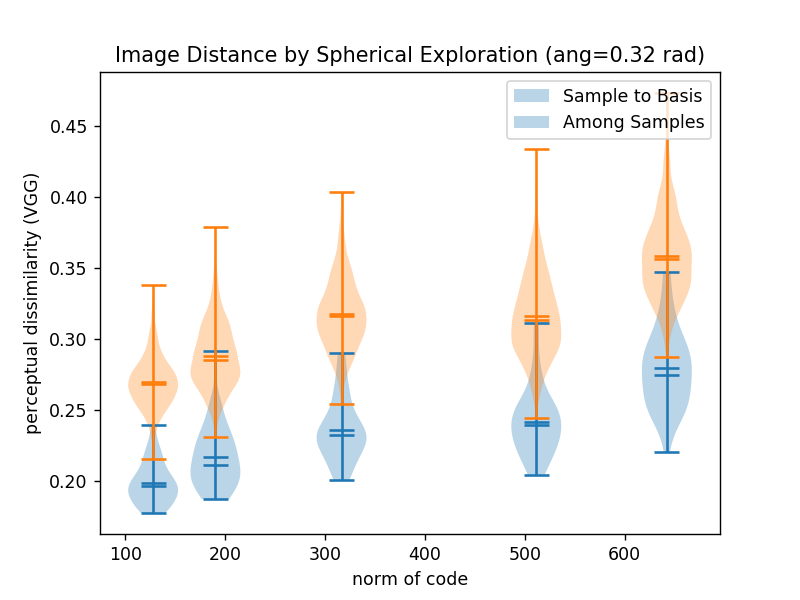

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [78]:
plt.figure()
plt.violinplot(basis_dist_sph_col, basis_norm_col, points=50, widths=50,
                      showmeans=True, showextrema=True, showmedians=True)
plt.violinplot(dist_mat_sph_col, basis_norm_col, points=50, widths=50,
            showmeans=True, showextrema=True, showmedians=True)
plt.title("Image Distance by Spherical Exploration (ang=0.32 rad)")
plt.xlabel("norm of code")
plt.ylabel("perceptual dissimilarity (VGG)")
plt.legend(["Sample to Basis","Among Samples"])
plt.savefig(join(result_dir,"SampleSimilarity_Sphere0.5.png"))
plt.savefig(join(result_dir,"SampleSimilarity_Sphere0.5.eps"), format='eps')
plt.show()

In [51]:
mu = 0.0075
print("Perceptual Similarity Based on VGG, Spherical Exploration")
basis_norm_col = []
basis_dist_sph_col = []
dist_mat_sph_col = []
for ampl in [2, 3, 5, 8, 10]:
    basis = ampl * np.random.randn(1, 4096)
    tang_vecs = mu * np.random.randn(40, 4096)
    codes = ExpMap(basis, tang_vecs)
    tang_code_norm = norm(tang_vecs, axis=1)
    print("\nNorm of Basis %.2f "% norm(basis))
    print("Mean norm of angular exploration vector %.2f (%.2f, %.2f)"% (tang_code_norm.mean(), tang_code_norm.min(), tang_code_norm.max()))
    basis_norm_col.append(norm(basis))
    img_basis = torch_visualize(G_torch, basis, "cuda")
    img_list = [torch_visualize(G_torch, code, "cuda") for code in codes]

    dist_mat = np.zeros((len(codes), len(codes)))
    dist_to_basis = np.zeros(len(codes))
    for i in range(len(codes)):
        dist = model_vgg.forward(img_list[i], img_basis, normalize=True)
        dist_to_basis[i] = dist.squeeze().detach().cpu().numpy()
        for j in range(i+1, len(codes)):
            dist = model_vgg.forward(img_list[i], img_list[j], normalize=True)
            dist_mat[i, j] = dist.squeeze().detach().cpu().numpy()
    print("Mean distance to basis image %.2f (%.2f, %.2f)"%(dist_to_basis.mean(), dist_to_basis.min(), dist_to_basis.max()))
    dist_mat_vect = dist_mat[dist_mat.nonzero()]
    print("Mean distance among samples %.2f (%.2f, %.2f)"%(dist_mat_vect.mean(), dist_mat_vect.min(), dist_mat_vect.max()))
    basis_dist_sph_col.append(dist_to_basis)
    dist_mat_sph_col.append(dist_mat_vect)

Perceptual Similarity Based on VGG, Spherical Exploration

Norm of Basis 126.55 
Mean norm of angular exploration vector 0.48 (0.47, 0.49)
Mean distance to basis image 0.26 (0.20, 0.30)
Mean distance among samples 0.34 (0.27, 0.41)

Norm of Basis 194.23 
Mean norm of angular exploration vector 0.48 (0.47, 0.49)
Mean distance to basis image 0.26 (0.24, 0.31)
Mean distance among samples 0.34 (0.29, 0.42)

Norm of Basis 321.64 
Mean norm of angular exploration vector 0.48 (0.47, 0.49)
Mean distance to basis image 0.34 (0.29, 0.40)
Mean distance among samples 0.43 (0.36, 0.51)

Norm of Basis 519.31 
Mean norm of angular exploration vector 0.48 (0.47, 0.49)
Mean distance to basis image 0.38 (0.33, 0.44)
Mean distance among samples 0.47 (0.39, 0.55)

Norm of Basis 646.98 
Mean norm of angular exploration vector 0.48 (0.47, 0.49)
Mean distance to basis image 0.33 (0.27, 0.40)
Mean distance among samples 0.42 (0.33, 0.52)


In [52]:
ang_explor_norm = [0.48, 0.48, 0.48, 0.48, 0.48]
np.savez(join(result_dir,"Repr_Dist_mu0.75.npz"), basis_dist_col=basis_dist_sph_col, dist_mat_col=dist_mat_sph_col, 
         basis_norm=basis_norm_col, ang_explor_norm=ang_explor_norm)

In [86]:
list(dist_mat_sph_col)

[array([0.34080023, 0.31880087, 0.35338598, 0.34665594, 0.34416938,
        0.30539   , 0.3317025 , 0.36309999, 0.33618006, 0.34112802,
        0.37085754, 0.35062343, 0.3761794 , 0.30710292, 0.36636096,
        0.3582367 , 0.33976901, 0.31310207, 0.32440358, 0.34217685,
        0.32376778, 0.3471458 , 0.32357609, 0.35341138, 0.30853426,
        0.33295381, 0.3259182 , 0.32379559, 0.35812792, 0.35715255,
        0.31658334, 0.34321982, 0.34342998, 0.32688421, 0.33857405,
        0.33995444, 0.33260226, 0.315687  , 0.33999687, 0.31796616,
        0.36094096, 0.3470763 , 0.34314236, 0.32305008, 0.31175655,
        0.34725845, 0.3294645 , 0.3111459 , 0.33949274, 0.37836999,
        0.36450326, 0.32123819, 0.38020259, 0.37150097, 0.3303771 ,
        0.36062348, 0.33271664, 0.3523806 , 0.33304834, 0.34576452,
        0.33168125, 0.33442679, 0.33555406, 0.352871  , 0.3614693 ,
        0.31624925, 0.34213686, 0.37890714, 0.35887015, 0.34579146,
        0.34027618, 0.36648938, 0.33963671, 0.36

<IPython.core.display.Javascript object>


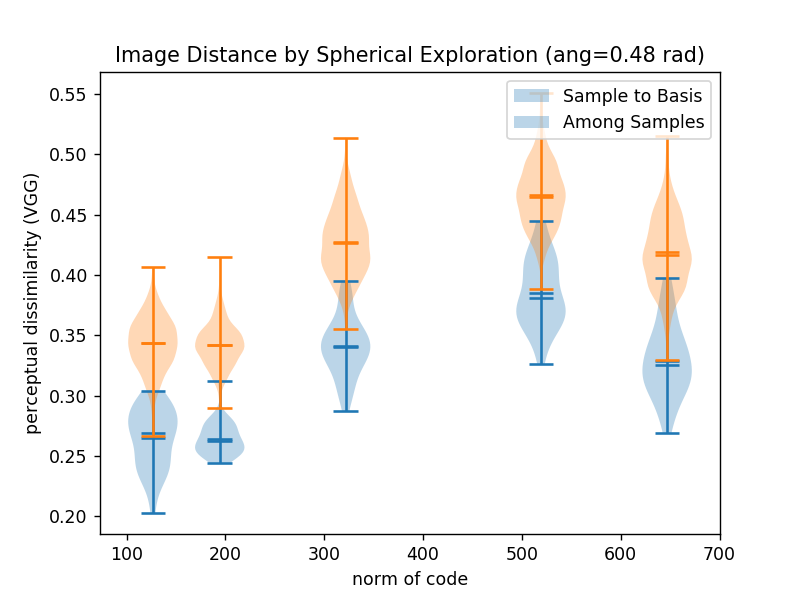

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [87]:
with np.load(join(result_dir,"Repr_Dist_mu0.75.npz")) as data:
    basis_norm_col = list(data['basis_norm'])
    basis_dist_sph_col = list(data['basis_dist_col'])
    dist_mat_sph_col = list(data['dist_mat_col'])

plt.figure()
plt.violinplot(basis_dist_sph_col, basis_norm_col, points=50, widths=50,
                      showmeans=True, showextrema=True, showmedians=True)
plt.violinplot(dist_mat_sph_col, basis_norm_col, points=50, widths=50,
            showmeans=True, showextrema=True, showmedians=True)
plt.xlabel("norm of code")
plt.ylabel("perceptual dissimilarity (VGG)")
plt.title("Image Distance by Spherical Exploration (ang=0.48 rad)")
plt.legend(["Sample to Basis","Among Samples"])
plt.savefig(join(result_dir,"SampleSimilarity_Sphere0.75.png"))
plt.savefig(join(result_dir,"SampleSimilarity_Sphere0.75.eps"), format='eps')
plt.show()

<IPython.core.display.Javascript object>


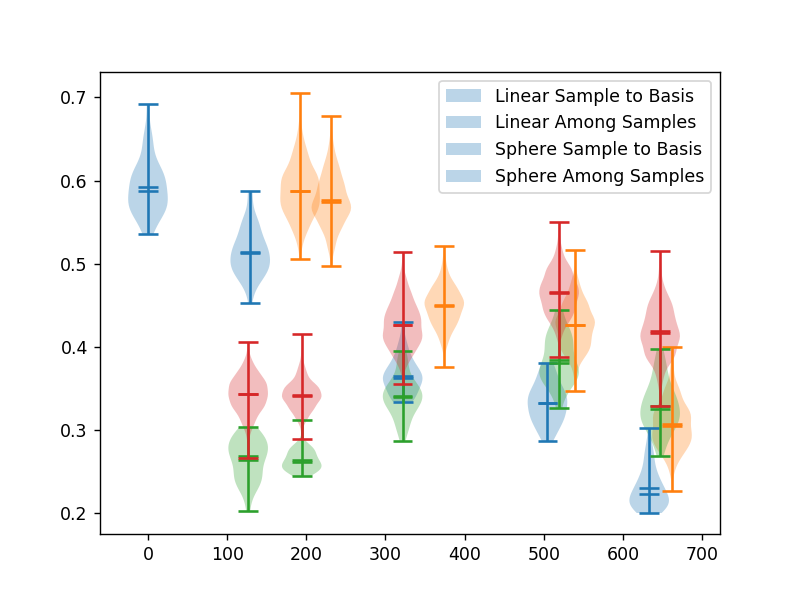

In [70]:
plt.figure()
plt.violinplot(basis_dist_col, basis_norm, points=50, widths=50,
            showmeans=True, showextrema=True, showmedians=True)
plt.violinplot(dist_mat_col, explor_norm, points=50, widths=50,
            showmeans=True, showextrema=True, showmedians=True)
plt.violinplot(basis_dist_sph_col, basis_norm_col, points=50, widths=50,
                      showmeans=True, showextrema=True, showmedians=True)
plt.violinplot(dist_mat_sph_col, basis_norm_col, points=50, widths=50,
            showmeans=True, showextrema=True, showmedians=True)
plt.legend(["Linear Sample to Basis","Linear Among Samples","Sphere Sample to Basis","Sphere Among Samples"])
plt.show()

## Scratch

In [31]:
print("Perceptual Similarity Based on VGG")
basis = 2 * np.random.randn(1, 4096)
sigma = 3.0
codes = sigma * np.random.randn(40, 4096) + basis
code_norm = norm(codes, axis=1)
print("Norm of Basis %.2f "% norm(basis))
print("Mean norm of exploration vector %.2f (%.2f, %.2f)"% (code_norm.mean(), code_norm.min(), code_norm.max()))
img_basis = torch_visualize(G_torch, basis, "cuda")
img_list = [torch_visualize(G_torch, code, "cuda") for code in codes]

dist_mat = np.zeros((len(codes), len(codes)))
dist_to_basis = np.zeros(len(codes))
for i in range(len(codes)):
    dist = model_vgg.forward(img_list[i], img_basis, normalize=True)
    dist_to_basis[i] = dist.squeeze().detach().cpu().numpy()
    for j in range(i+1, len(codes)):
        dist = model_vgg.forward(img_list[i], img_list[j], normalize=True)
        dist_mat[i, j] = dist.squeeze().detach().cpu().numpy()
print("Mean distance to basis image %.2f (%.2f, %.2f)"%(dist_to_basis.mean(), dist_to_basis.min(), dist_to_basis.max()))
dist_mat_vect = dist_mat[dist_mat.nonzero()]
print("Mean distance among samples %.2f (%.2f, %.2f)"%(dist_mat_vect.mean(), dist_mat_vect.min(), dist_mat_vect.max()))

Perceptual Similarity Based on VGG
Norm of Basis 128.54 
Mean norm of exploration vector 230.59 (227.30, 234.42)
Mean distance to basis image 0.51 (0.45, 0.59)
Mean distance among samples 0.57 (0.47, 0.67)


In [32]:
print("Perceptual Similarity Based on VGG")
basis = 5 * np.random.randn(1, 4096)
sigma = 3.0
codes = sigma * np.random.randn(40, 4096) + basis
code_norm = norm(codes, axis=1)
print("Norm of Basis %.2f "% norm(basis))
print("Mean norm of exploration vector %.2f (%.2f, %.2f)"% (code_norm.mean(), code_norm.min(), code_norm.max()))
img_basis = torch_visualize(G_torch, basis, "cuda")
img_list = [torch_visualize(G_torch, code, "cuda") for code in codes]

dist_mat = np.zeros((len(codes), len(codes)))
dist_to_basis = np.zeros(len(codes))
for i in range(len(codes)):
    dist = model_vgg.forward(img_list[i], img_basis, normalize=True)
    dist_to_basis[i] = dist.squeeze().detach().cpu().numpy()
    for j in range(i+1, len(codes)):
        dist = model_vgg.forward(img_list[i], img_list[j], normalize=True)
        dist_mat[i, j] = dist.squeeze().detach().cpu().numpy()
print("Mean distance to basis image %.2f (%.2f, %.2f)"%(dist_to_basis.mean(), dist_to_basis.min(), dist_to_basis.max()))
dist_mat_vect = dist_mat[dist_mat.nonzero()]
print("Mean distance among samples %.2f (%.2f, %.2f)"%(dist_mat_vect.mean(), dist_mat_vect.min(), dist_mat_vect.max()))

Perceptual Similarity Based on VGG
Norm of Basis 320.31 
Mean norm of exploration vector 372.42 (366.08, 378.60)
Mean distance to basis image 0.37 (0.32, 0.44)
Mean distance among samples 0.46 (0.38, 0.55)


In [33]:
print("Perceptual Similarity Based on VGG")
basis = 8 * np.random.randn(1, 4096)
sigma = 3.0
codes = sigma * np.random.randn(40, 4096) + basis
code_norm = norm(codes, axis=1)
print("Norm of Basis %.2f "% norm(basis))
print("Mean norm of exploration vector %.2f (%.2f, %.2f)"% (code_norm.mean(), code_norm.min(), code_norm.max()))
img_basis = torch_visualize(G_torch, basis, "cuda")
img_list = [torch_visualize(G_torch, code, "cuda") for code in codes]

dist_mat = np.zeros((len(codes), len(codes)))
dist_to_basis = np.zeros(len(codes))
for i in range(len(codes)):
    dist = model_vgg.forward(img_list[i], img_basis, normalize=True)
    dist_to_basis[i] = dist.squeeze().detach().cpu().numpy()
    for j in range(i+1, len(codes)):
        dist = model_vgg.forward(img_list[i], img_list[j], normalize=True)
        dist_mat[i, j] = dist.squeeze().detach().cpu().numpy()
print("Mean distance to basis image %.2f (%.2f, %.2f)"%(dist_to_basis.mean(), dist_to_basis.min(), dist_to_basis.max()))
dist_mat_vect = dist_mat[dist_mat.nonzero()]
print("Mean distance among samples %.2f (%.2f, %.2f)"%(dist_mat_vect.mean(), dist_mat_vect.min(), dist_mat_vect.max()))

Perceptual Similarity Based on VGG
Norm of Basis 505.30 
Mean norm of exploration vector 540.43 (534.31, 546.57)
Mean distance to basis image 0.31 (0.27, 0.36)
Mean distance among samples 0.40 (0.31, 0.48)


In [ ]:
sigma = 3.0
codes = sigma * np.random.randn(40, 4096)
img_list = [visualize(G_torch, code, "cuda") for code in codes]
#%
dist_mat = np.zeros((len(codes), len(codes)))
for i in range(len(codes)):
    for j in range(len(codes)):
        dist = model_squ.forward(img_list[i].unsqueeze(0).permute(0,3,1,2), img_list[j].unsqueeze(0).permute(0,3,1,2), normalize=True)
        dist_mat[i, j] = dist.squeeze().detach().cpu().numpy()
dist_mat.mean()
#%%
basis = 5 * np.random.randn(1, 4096)
sigma = 3.0
codes = sigma * np.random.randn(40, 4096) + basis
img_list = [visualize(G_torch, code, "cuda") for code in codes]
dist_mat2 = np.zeros((len(codes), len(codes)))
for i in range(len(codes)):
    for j in range(len(codes)):
        dist = model_squ.forward(img_list[i].unsqueeze(0).permute(0,3,1,2), img_list[j].unsqueeze(0).permute(0,3,1,2), normalize=True)
        dist_mat2[i, j] = dist.squeeze().detach().cpu().numpy()
#%
dist_mat2.mean()
#%%
basis = 8 * np.random.randn(1, 4096)
sigma = 3.0
codes3 = sigma * np.random.randn(40, 4096) + basis
img_list = [visualize(G_torch, code, "cuda") for code in codes3]
dist_mat3 = np.zeros((len(codes), len(codes)))
for i in range(len(codes3)):
    for j in range(len(codes3)):
        dist = model_squ.forward(img_list[i].unsqueeze(0).permute(0,3,1,2), img_list[j].unsqueeze(0).permute(0, 3, 1, 2), normalize=True)
        dist_mat3[i, j] = dist.squeeze().detach().cpu().numpy()
#%
dist_mat3.mean()
